In [41]:
# basic packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


In [42]:
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.DataFrame(data.target, columns=['MedHouseVal'])

X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [43]:
X.shape

(20640, 8)

In [44]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (common preprocessing step)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## PyTorch Setup for Regression (Price Prediction)

In [45]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim



In [46]:
# Convert data to PyTorch tensors (backend setup)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for batching
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)


In [47]:
# Create the model
class RegressionNN(nn.Module):
    def __init__(self, input_size=8):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1) # 1 output for house value prediction

    def forward(self, x):
      # functional API
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [48]:
# Initialize the model, loss function, and optimizer
pytorch_model = RegressionNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=0.001)


In [49]:
!pip install torchsummary

In [50]:
from torchsummary import summary
print("PyTorch Model Summary:")
summary(pytorch_model, input_size=(8,))

PyTorch Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             576
            Linear-2                   [-1, 32]           2,080
            Linear-3                    [-1, 1]              33
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [51]:
def train_regression(train_loader, model, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward() # backpropagation
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


train_regression(train_loader, pytorch_model, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.9774379895408024
Epoch 2/10, Loss: 0.4293596780057563
Epoch 3/10, Loss: 0.39554992901493413
Epoch 4/10, Loss: 0.3782799351931542
Epoch 5/10, Loss: 0.36201374071050985
Epoch 6/10, Loss: 0.33818529920233775
Epoch 7/10, Loss: 0.3285635994646207
Epoch 8/10, Loss: 0.32705942070645877
Epoch 9/10, Loss: 0.31508776601837124
Epoch 10/10, Loss: 0.3095848806664463


In [52]:
def eval_regression(test_loader, model):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            test_loss += loss.item()
    return test_loss / len(test_loader)

test_loss = eval_regression(test_loader, pytorch_model)
print(f"Test Loss: {test_loss}")

Test Loss: 0.32537672247073446


In [53]:
# Get a batch of data from the training set in PyTorch
data_iter = iter(train_loader)
X_batch, y_batch = next(data_iter)


# Forward pass through the model to get predictions (continuous values for regression)
outputs = pytorch_model(X_batch)

# Print the predicted values and actual values for the batch (regression outputs)
print(f'Predicted values (PyTorch): {outputs.squeeze().detach().numpy()}')  # Squeeze and convert to numpy for readability
print(f'Actual values (PyTorch): {y_batch.squeeze().detach().numpy()}')  # Squeeze and convert to numpy for readability

# Calculate the Mean Squared Error (MSE) for this batch
mse_loss = nn.MSELoss()
loss = mse_loss(outputs, y_batch)
print(f'Mean Squared Error for this batch (PyTorch): {loss.item()}')


Predicted values (PyTorch): [4.2845664  0.75736177 0.7334819  2.9114406  1.7905616  3.1194544
 2.7300963  2.7075107  1.988818   1.5303407  6.452503   1.0764937
 2.8756208  2.3506486  1.4218271  1.0827767  2.91194    2.7455037
 3.3610847  1.4575156  1.639481   2.6508977  4.100216   4.0619464
 4.0422235  2.871984   1.1484269  3.1439846  1.4380093  2.4656515
 4.6963935  1.4881167 ]
Actual values (PyTorch): [5.00001 0.5     0.719   2.766   1.55    2.5     4.383   1.054   2.293
 1.53    5.00001 0.825   2.566   2.021   1.425   1.319   3.      2.125
 2.869   1.818   2.583   3.5     2.5     3.842   3.218   2.105   0.894
 2.335   0.948   2.013   5.00001 1.384  ]
Mean Squared Error for this batch (PyTorch): 0.5172832608222961


Epoch [1/50], Train Loss: 0.3070, Test Loss: 0.3153
Epoch [2/50], Train Loss: 0.3010, Test Loss: 0.3178
Epoch [3/50], Train Loss: 0.2974, Test Loss: 0.3056
Epoch [4/50], Train Loss: 0.2951, Test Loss: 0.3036
Epoch [5/50], Train Loss: 0.2965, Test Loss: 0.3000
Epoch [6/50], Train Loss: 0.2946, Test Loss: 0.2996
Epoch [7/50], Train Loss: 0.2894, Test Loss: 0.3166
Epoch [8/50], Train Loss: 0.2863, Test Loss: 0.3042
Epoch [9/50], Train Loss: 0.2847, Test Loss: 0.3096
Epoch [10/50], Train Loss: 0.2827, Test Loss: 0.2982
Epoch [11/50], Train Loss: 0.2820, Test Loss: 0.2914
Epoch [12/50], Train Loss: 0.2823, Test Loss: 0.2901
Epoch [13/50], Train Loss: 0.2803, Test Loss: 0.2876
Epoch [14/50], Train Loss: 0.2766, Test Loss: 0.2964
Epoch [15/50], Train Loss: 0.2763, Test Loss: 0.2884
Epoch [16/50], Train Loss: 0.2742, Test Loss: 0.2856
Epoch [17/50], Train Loss: 0.2760, Test Loss: 0.2862
Epoch [18/50], Train Loss: 0.2774, Test Loss: 0.2861
Epoch [19/50], Train Loss: 0.2719, Test Loss: 0.2913
Ep

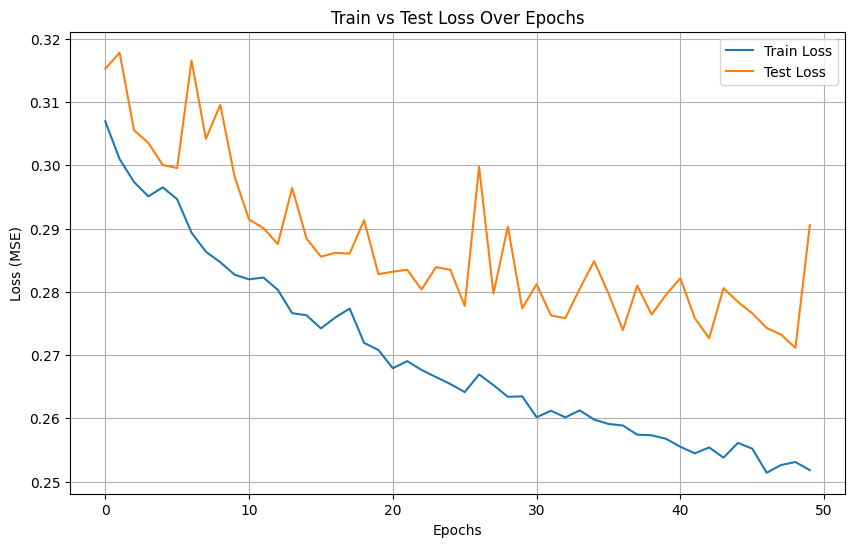

In [54]:
# Function to train the model and collect loss values for plotting
def train_regression_with_curves(train_loader, test_loader, model, criterion, optimizer, epochs=20):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Average loss for this epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Evaluate on the test set after each epoch
        test_loss = evaluate_regression(test_loader, model)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, test_losses

# Evaluate the model on the test set
def evaluate_regression(test_loader, model):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            test_loss += loss.item()
    return test_loss / len(test_loader)

# Train the model and collect train/test losses
train_losses, test_losses = train_regression_with_curves(train_loader, test_loader, pytorch_model, criterion, optimizer, epochs=50)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Train vs Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


## Keras Setup for Regression (Price Prediction)

In [55]:
##################################
# Keras Setup for Regression
##################################
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [56]:
# Define a simple neural network for regression using Keras
model_keras = Sequential()
model_keras.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model_keras.add(Dense(32, activation='relu'))
model_keras.add(Dense(1))  # Single output for regression


# Compile the Keras model
model_keras.compile(optimizer='adam', loss='mean_squared_error')


In [57]:
# Keras model structure visualization
print("Keras Model Structure:")
model_keras.summary()


Keras Model Structure:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                576       
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2689 (10.50 KB)
Trainable params: 2689 (10.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
# Train the Keras model
history = model_keras.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
516/516 [==============================] - 2s 2ms/step - loss: 0.9048 - val_loss: 0.4666
Epoch 2/50
516/516 [==============================] - 1s 2ms/step - loss: 0.4066 - val_loss: 0.3967
Epoch 3/50
516/516 [==============================] - 1s 2ms/step - loss: 0.3736 - val_loss: 0.3709
Epoch 4/50
516/516 [==============================] - 1s 2ms/step - loss: 0.3541 - val_loss: 0.3713
Epoch 5/50
516/516 [==============================] - 1s 2ms/step - loss: 0.3435 - val_loss: 0.3489
Epoch 6/50
516/516 [==============================] - 1s 2ms/step - loss: 0.3783 - val_loss: 0.3465
Epoch 7/50
516/516 [==============================] - 1s 2ms/step - loss: 0.3325 - val_loss: 0.3373
Epoch 8/50
516/516 [==============================] - 1s 2ms/step - loss: 0.3177 - val_loss: 0.3518
Epoch 9/50
516/516 [==============================] - 1s 2ms/step - loss: 0.3174 - val_loss: 0.3262
Epoch 10/50
516/516 [==============================] - 1s 2ms/step - loss: 0.3119 - val_loss: 0.3375

In [59]:
# Evaluate the Keras model on a single batch
X_batch = X_train[:32]  # First 32 samples
y_batch = y_train[:32]
y_pred = model_keras.predict(X_batch)

# Display predicted and actual values in Keras
print(f'Predicted values (Keras): {y_pred.flatten()}')
print(f'Actual values (Keras): {y_batch.values.flatten()}')


1/1 [==============================] - 0s 51ms/step
Predicted values (Keras): [1.2790401  3.8271065  2.0638287  1.0407965  1.0769551  2.9731698
 1.539097   4.636314   1.6638235  2.7968092  2.7071805  2.1407413
 1.2040315  1.3879347  1.9807138  1.7413322  2.1730356  1.5432447
 1.7723191  1.4670018  0.93223214 4.938828   1.2887195  1.1765118
 0.8610941  3.5323567  0.6375417  1.7758553  2.4245431  1.3792472
 1.4129938  1.6927116 ]
Actual values (Keras): [1.03    3.821   1.726   0.934   0.965   2.648   1.573   5.00001 1.398
 3.156   2.319   1.594   0.96    1.875   2.299   1.177   1.696   1.308
 1.574   0.941   0.727   5.00001 0.958   0.975   0.788   2.92    0.425
 1.875   2.182   0.875   1.463   1.374  ]


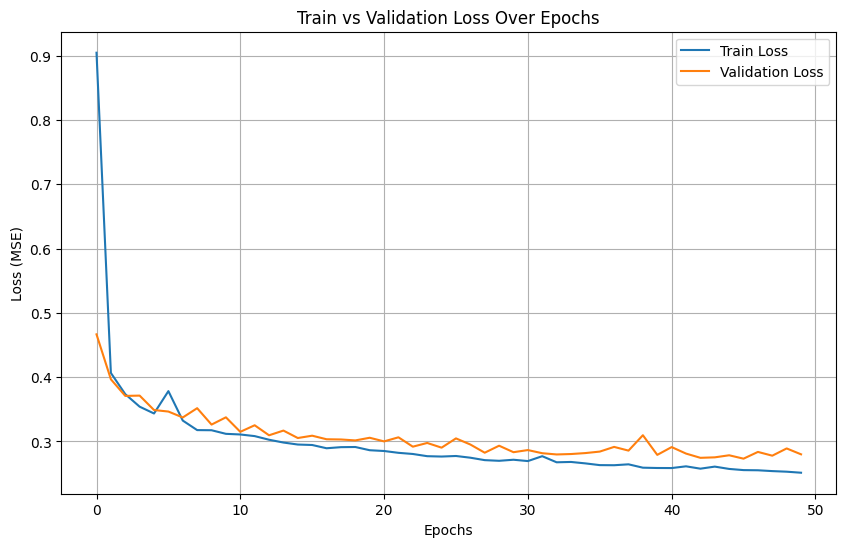

In [60]:
# Step 3: Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Train vs Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
